In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
full_train = pd.read_csv('https://raw.githubusercontent.com/NHANGIOI/Machine-Deep-Learning/refs/heads/main/Predicting%20Student%20Test%20Scores/train.csv')
x_test = pd.read_csv('https://raw.githubusercontent.com/NHANGIOI/Machine-Deep-Learning/refs/heads/main/Predicting%20Student%20Test%20Scores/test.csv')

test_id = x_test['id']
full_train.drop(columns = 'id',inplace = True)
x_test.drop(columns = 'id',inplace = True)

x_train,x_valid,y_train,y_valid = train_test_split(full_train.copy().drop(columns = 'exam_score'),full_train['exam_score'],
                                                   train_size = 0.8,test_size = 0.2,random_state = 0)

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.impute import SimpleImputer

OH_cols = [col for col in x_train.columns if x_train[col].dtype == 'object' and x_train[col].nunique() <= 10]
OR_cols = [col for col in x_train.columns if x_train[col].dtype == 'object' and col not in OH_cols]

pre_process = ColumnTransformer(transformers = [
    ('OH_encode',OneHotEncoder(handle_unknown = 'ignore'),OH_cols),
    ('OR_encode',OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1),OR_cols)
])

x_train = pre_process.fit_transform(x_train).toarray()
x_valid = pre_process.transform(x_valid).toarray()
x_test = pre_process.transform(x_test).toarray()

In [ ]:
print(x_train.shape)

(504000, 26)


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
model = keras.Sequential([
    keras.Input(shape = [x_train.shape[1]]),
    layers.Dense(units = 32,activation = 'relu'),
    layers.Dense(units = 32,activation = 'relu'),
    layers.Dense(units = 16,activation = 'relu'),
    layers.Dense(units = 16,activation = 'relu'),
    layers.Dense(units = 8,activation = 'relu'),
    layers.Dense(units = 4,activation = 'relu'),
    layers.Dense(units = 4,activation = 'relu'),
    layers.Dense(units = 1),
])

early_stopping = callbacks.EarlyStopping(
    min_delta = 0.05,
    patience = 50,
    restore_best_weights = True,
)
model.compile(
    #optimizer = 'adam',
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    loss = 'mae'
)
train_process = model.fit(
    x_train,y_train,
    validation_data = (x_valid,y_valid),
    batch_size = 8192,
    epochs = 100,
    callbacks = [early_stopping]
)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 62.4555 - val_loss: 62.4520
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 61.5043 - val_loss: 40.5681
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 23.6917 - val_loss: 15.0377
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.9021 - val_loss: 14.6135
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.5549 - val_loss: 14.5099
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 14.4707 - val_loss: 14.4992
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 14.4452 - val_loss: 14.4990
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 14.4401 - val_loss: 14.4987
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 14.4828 - val_loss: 14.4988
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.4580 - val_loss: 14.4981
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.4459 - val_loss: 14.4982
Epoch 12/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 

<Axes: >

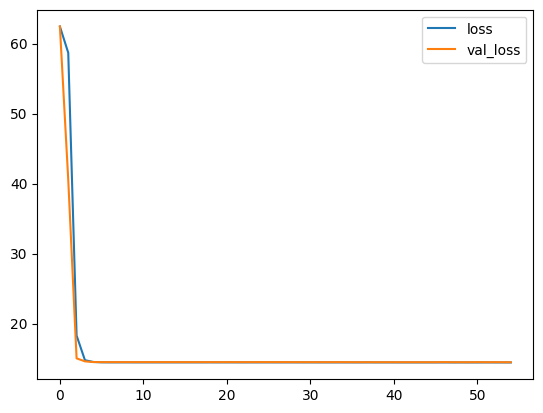

In [5]:
from matplotlib.pyplot import plot
history_df = pd.DataFrame(train_process.history)
history_df.loc[:, ['loss', 'val_loss']].plot()